In [1]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset, random_split
import time
import numpy as np
from sklearn.metrics import precision_score, recall_score
import matplotlib.pyplot as plt

### <b>Load data</b>
Visualize and check the binary distribution

In [2]:
# load data
data = np.load("phaselink.npz")
X = data["X"]   # (100000, np, 5),where np is a sliding window length (length of a subsequence)
# 5 dimensions are lat, lon, time, type, zero padding
Y = data["Y"]   # the first pick of the sequence

### <b>A built-in LSTM</b>
see below for the model and the trainer

In [3]:
class PhaseLink_LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, output_size=1):
        super(PhaseLink_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc   = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        h_lstm, _ = self.lstm(x)
        out = self.sigmoid(self.fc(h_lstm))
        return out

In [4]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, device):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device
    
    def train(self, num_epochs):
        self.model.to(self.device)

        # ========== training loop ==========
        # loss precision recall
        train_losses = []
        train_precisions = []
        train_recalls = []
        test_losses = []
        test_precisions = []
        test_recalls = []

        # starting time
        start_time = time.time()
        # loop
        for epoch in range(num_epochs):
            self.model.train()
            
            epoch_losses = []
            all_preds = []
            all_labels = []
            for batch_X, batch_Y in self.train_loader:
                batch_X = batch_X.to(self.device).float()
                batch_Y = batch_Y.to(self.device).float()
                
                # Forward pass
                outputs = self.model(batch_X).squeeze(-1)
                loss = self.criterion(outputs, batch_Y)
                
                # Backward pass and optimization
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                
                # Record loss
                epoch_losses.append(loss.item())
                
                # Predictions
                preds = (outputs >= 0.5).float()
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(batch_Y.cpu().numpy())
            
            # Compute metrics
            epoch_loss = np.mean(epoch_losses)
            all_labels = np.array(all_labels).flatten()
            all_preds  = np.array(all_preds).flatten()
            epoch_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
            epoch_recall    = recall_score(all_labels, all_preds, average=None, zero_division=0)
            
            train_losses.append(epoch_loss)
            train_precisions.append(epoch_precision)
            train_recalls.append(epoch_recall)
            
            print(
                f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f} | " + 
                f"Precision for class 0: {epoch_precision[0]:.4f}, class 1: {epoch_precision[1]:.4f} | " +
                f"Recall for class 0: {epoch_recall[0]:.4f}, class 1: {epoch_recall[1]:.4f} "
            )

            # ========== testing loop ==========
            self.model.eval()

            with torch.no_grad():
                all_preds  = []
                all_labels = []
                test_loss = []
                for batch_X, batch_Y in self.val_loader:
                    batch_X = batch_X.to(self.device).float()
                    batch_Y = batch_Y.to(self.device).float()
                    
                    # Forward pass
                    outputs = self.model(batch_X).squeeze(-1)
                    loss = self.criterion(outputs, batch_Y)
                    test_loss.append(loss.item())
                    
                    # Predictions
                    preds = (outputs >= 0.5).float()
                    all_preds.extend(preds.cpu().numpy())
                    all_labels.extend(batch_Y.cpu().numpy())
            
                # Compute metrics
                test_loss   = np.mean(test_loss)
                all_labels  = np.array(all_labels).flatten()
                all_preds   = np.array(all_preds).flatten()
                test_precision = precision_score(all_labels, all_preds, average=None, zero_division=0)
                test_recall = recall_score(all_labels, all_preds, average=None, zero_division=0)
                
                print(
                    f"Test Loss: {test_loss:.4f} | " + 
                    f"Precision for class 0: {test_precision[0]:.4f}, class 1: {test_precision[1]:.4f} | " +
                    f"Recall for class 0: {test_recall[0]:.4f}, class 1: {test_recall[1]:.4f} "
                    )
                
                test_losses.append(test_loss)
                test_precisions.append(test_precision)
                test_recalls.append(test_recall)
            
            # ========== test of convergence ==========
            if epoch > 5:
                if abs(train_losses[-1] - train_losses[-2]) < 1e-4:
                    print("Convergence reached, stopping training.")
                    break
                
        # total time
        end_time = time.time()
        print(f"Total training time: {end_time - start_time:.2f} seconds")
        return (train_losses, train_precisions, train_recalls), (test_losses, test_precisions, test_recalls)

In [5]:
# split dataset into train and test sets, 80% and 20%, each unit is a sequence
batch_size = 256
n_picks, len_seq, n_features = X.shape

X_tensor = torch.tensor(X, dtype=torch.float32)
Y_tensor = torch.tensor(Y, dtype=torch.float32)
dataset = TensorDataset(X_tensor, Y_tensor)
train_size = int(0.8 * n_picks)
test_size  = n_picks - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [6]:
hidden_size = 16

criterion   = nn.BCELoss()
device      = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [7]:
# try learning rate of 1, 0.1, 0.01, 0.001, 0.0001
lrs = [0.005, 0.001, 0.0005, 0.0001]
new_epochs = 100

train_losses_all = {}
test_losses_all  = {}
train_precisions_all = {}
test_precisions_all  = {}
train_recalls_all = {}
test_recalls_all  = {}

for lr in lrs:
    print(f"\nTraining with learning rate: {lr}")
    # re-initialize model and optimizer
    model     = PhaseLink_LSTM(n_features, hidden_size)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # trainer
    trainer = Trainer(
        model = model, 
        optimizer = optimizer, 
        train_loader = train_loader, 
        val_loader = test_loader, 
        criterion = criterion, 
        device = device
        )
    
    # train
    train_metrics, test_metrics = trainer.train(new_epochs)
    
    # store metrics
    train_losses_all[lr] = train_metrics[0]
    train_precisions_all[lr] = train_metrics[1]
    train_recalls_all[lr] = train_metrics[2]
    
    test_losses_all[lr] = test_metrics[0]
    test_precisions_all[lr] = test_metrics[1]
    test_recalls_all[lr] = test_metrics[2]


Training with learning rate: 0.005
Epoch [1/100], Loss: 0.1014 | Precision for class 0: 0.9733, class 1: 0.0000 | Recall for class 0: 1.0000, class 1: 0.0000 
Test Loss: 0.0515 | Precision for class 0: 0.9736, class 1: 0.0000 | Recall for class 0: 1.0000, class 1: 0.0000 
Epoch [2/100], Loss: 0.0503 | Precision for class 0: 0.9734, class 1: 0.5166 | Recall for class 0: 0.9999, class 1: 0.0030 
Test Loss: 0.0492 | Precision for class 0: 0.9737, class 1: 0.5122 | Recall for class 0: 0.9999, class 1: 0.0048 
Epoch [3/100], Loss: 0.0478 | Precision for class 0: 0.9779, class 1: 0.5559 | Recall for class 0: 0.9960, class 1: 0.1806 
Test Loss: 0.0447 | Precision for class 0: 0.9835, class 1: 0.5833 | Recall for class 0: 0.9925, class 1: 0.3864 
Epoch [4/100], Loss: 0.0438 | Precision for class 0: 0.9854, class 1: 0.5847 | Recall for class 0: 0.9910, class 1: 0.4629 
Test Loss: 0.0428 | Precision for class 0: 0.9861, class 1: 0.5842 | Recall for class 0: 0.9906, class 1: 0.4851 
Epoch [5/100

In [8]:
# save the dict
np.savez(
    "lstm1_training_metrics.npz",
    train_losses_all = train_losses_all,
    test_losses_all  = test_losses_all,
    train_precisions_all = train_precisions_all,
    test_precisions_all  = test_precisions_all,
    train_recalls_all = train_recalls_all,
    test_recalls_all  = test_recalls_all
)

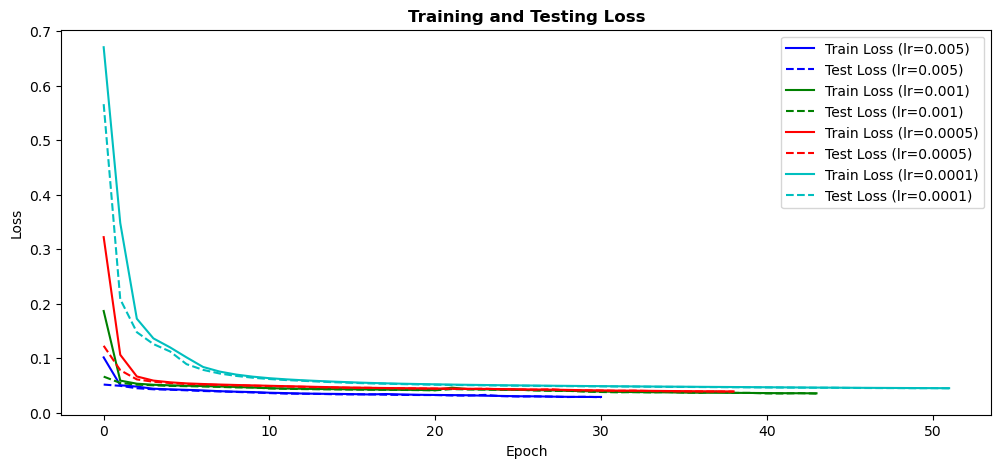

In [9]:
# plot loss
colors = ['b', 'g', 'r', 'c', 'm']
plt.figure(figsize=(12, 5))
for i, lr in enumerate(lrs):
    plt.plot(train_losses_all[lr], color=colors[i], label=f'Train Loss (lr={lr})')
    plt.plot(test_losses_all[lr], color=colors[i], linestyle='--', label=f'Test Loss (lr={lr})')

plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Testing Loss', fontweight='bold')
plt.legend()

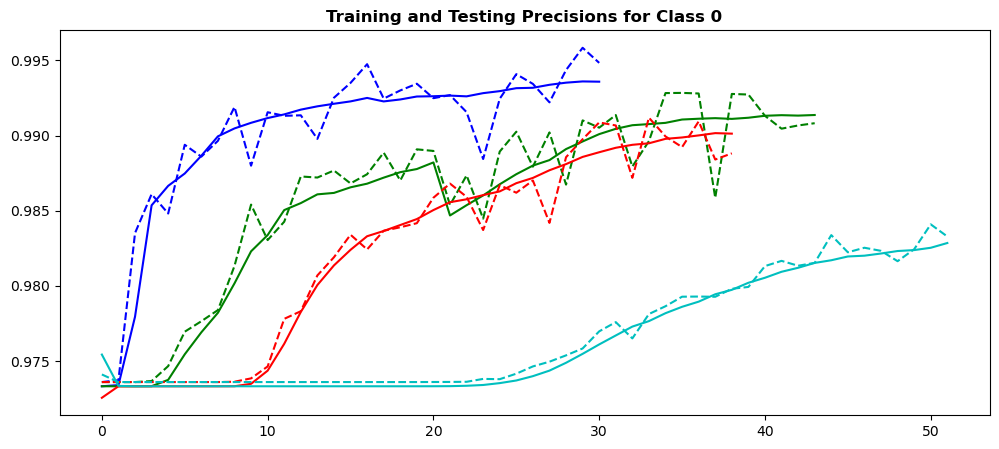

In [10]:
# plot precision for class 0
plt.figure(figsize=(12, 5))
plt.title('Training and Testing Precisions for Class 0', fontweight='bold')
for i, lr in enumerate(lrs):
    train_precisions = np.array(train_precisions_all[lr])
    test_precisions  = np.array(test_precisions_all[lr])
    plt.plot(train_precisions[:, 0], color=colors[i], label=f'Train Precision Class 0 (lr={lr})')
    plt.plot(test_precisions[:, 0], color=colors[i], linestyle='--', label=f'Test Precision Class 0 (lr={lr})')

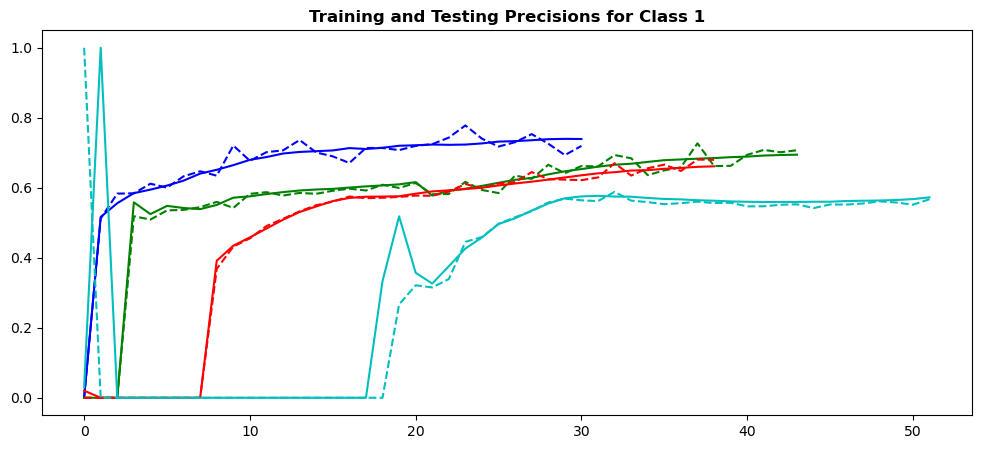

In [11]:
# precision for class 1
plt.figure(figsize=(12, 5))
plt.title('Training and Testing Precisions for Class 1', fontweight='bold')
for i, lr in enumerate(lrs):
    train_precisions = np.array(train_precisions_all[lr])
    test_precisions  = np.array(test_precisions_all[lr])
    plt.plot(train_precisions[:, 1], color=colors[i], label=f'Train Precision Class 1 (lr={lr})')
    plt.plot(test_precisions[:, 1], color=colors[i], linestyle='--', label=f'Test Precision Class 1 (lr={lr})')

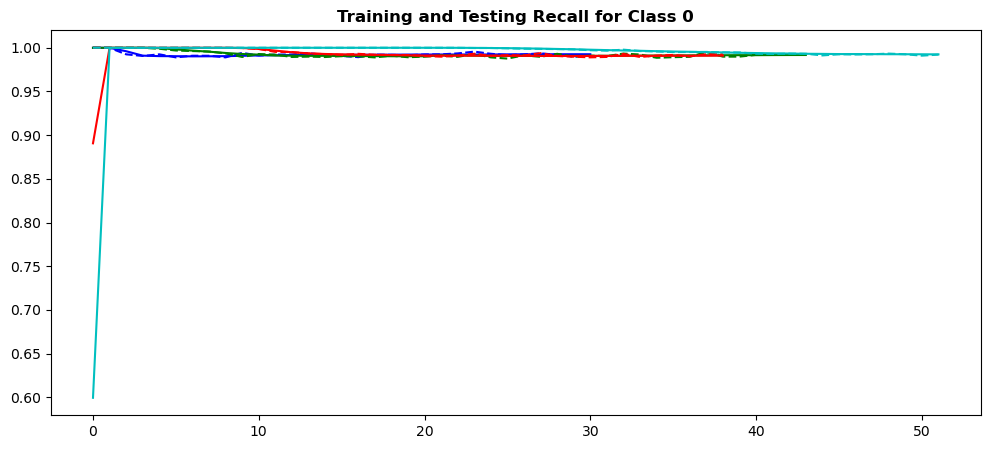

In [15]:
# recall for class 0
plt.figure(figsize=(12, 5))
plt.title('Training and Testing Recall for Class 0', fontweight='bold')
for i, lr in enumerate(lrs):
    train_recalls = np.array(train_recalls_all[lr])
    test_recalls  = np.array(test_recalls_all[lr])
    plt.plot(train_recalls[:, 0], color=colors[i], label=f'Train Recall Class 0 (lr={lr})')
    plt.plot(test_recalls[:, 0], color=colors[i], linestyle='--', label=f'Test Recall Class 0 (lr={lr})')

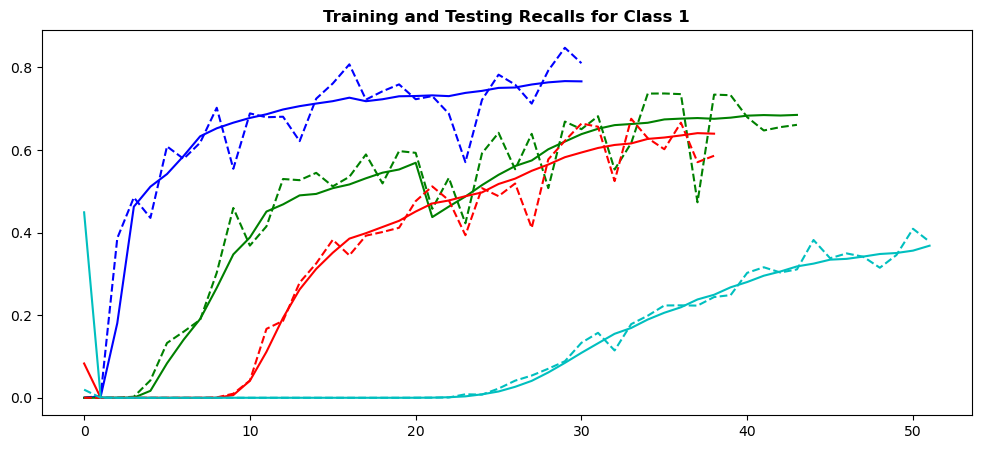

In [13]:
# recall for class 1
plt.figure(figsize=(12, 5))
plt.title('Training and Testing Recalls for Class 1', fontweight='bold')
for i, lr in enumerate(lrs):
    train_recalls = np.array(train_recalls_all[lr])
    test_recalls  = np.array(test_recalls_all[lr])
    plt.plot(train_recalls[:, 1], color=colors[i], label=f'Train Recall Class 1 (lr={lr})')
    plt.plot(test_recalls[:, 1], color=colors[i], linestyle='--', label=f'Test Recall Class 1 (lr={lr})')

### <b>Increase hidden size by a factor of 2</b>

In [14]:
# new hidden units
hidden_size_new = 32
# new dicts
train_losses_all_new = {}
test_losses_all_new  = {}
train_precisions_all_new = {}
test_precisions_all_new  = {}
train_recalls_all_new = {}
test_recalls_all_new  = {}

# loop over lrs
for lr in lrs:
    print(f"\nTraining with learning rate: {lr} and hidden size: {hidden_size_new}")
    # re-initialize model and optimizer
    model     = PhaseLink_LSTM(n_features, hidden_size_new)
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    
    # trainer
    trainer = Trainer(
        model = model, 
        optimizer = optimizer, 
        train_loader = train_loader, 
        val_loader = test_loader, 
        criterion = criterion, 
        device = device
        )
    
    # train
    train_metrics, test_metrics = trainer.train(new_epochs)
    
    # store metrics
    train_losses_all_new[lr] = train_metrics[0]
    train_precisions_all_new[lr] = train_metrics[1]
    train_recalls_all_new[lr] = train_metrics[2]
    
    test_losses_all_new[lr] = test_metrics[0]
    test_precisions_all_new[lr] = test_metrics[1]
    test_recalls_all_new[lr] = test_metrics[2]

# save
np.savez(
    "lstm1_training_metrics_hidden32.npz",
    train_losses_all = train_losses_all_new,
    test_losses_all  = test_losses_all_new,
    train_precisions_all = train_precisions_all_new,
    test_precisions_all  = test_precisions_all_new,
    train_recalls_all = train_recalls_all_new,
    test_recalls_all  = test_recalls_all_new
)


Training with learning rate: 0.005 and hidden size: 32
Epoch [1/100], Loss: 0.0981 | Precision for class 0: 0.9733, class 1: 0.0170 | Recall for class 0: 0.9942, class 1: 0.0037 
Test Loss: 0.0506 | Precision for class 0: 0.9736, class 1: 0.0000 | Recall for class 0: 1.0000, class 1: 0.0000 
Epoch [2/100], Loss: 0.0476 | Precision for class 0: 0.9775, class 1: 0.5842 | Recall for class 0: 0.9968, class 1: 0.1642 
Test Loss: 0.0446 | Precision for class 0: 0.9830, class 1: 0.5777 | Recall for class 0: 0.9927, class 1: 0.3685 
Epoch [3/100], Loss: 0.0443 | Precision for class 0: 0.9843, class 1: 0.5781 | Recall for class 0: 0.9915, class 1: 0.4242 
Test Loss: 0.0438 | Precision for class 0: 0.9832, class 1: 0.5888 | Recall for class 0: 0.9929, class 1: 0.3752 
Epoch [4/100], Loss: 0.0432 | Precision for class 0: 0.9860, class 1: 0.5793 | Recall for class 0: 0.9903, class 1: 0.4862 
Test Loss: 0.0425 | Precision for class 0: 0.9884, class 1: 0.5702 | Recall for class 0: 0.9883, class 1: 

Text(0.5, 0, 'Epochs')

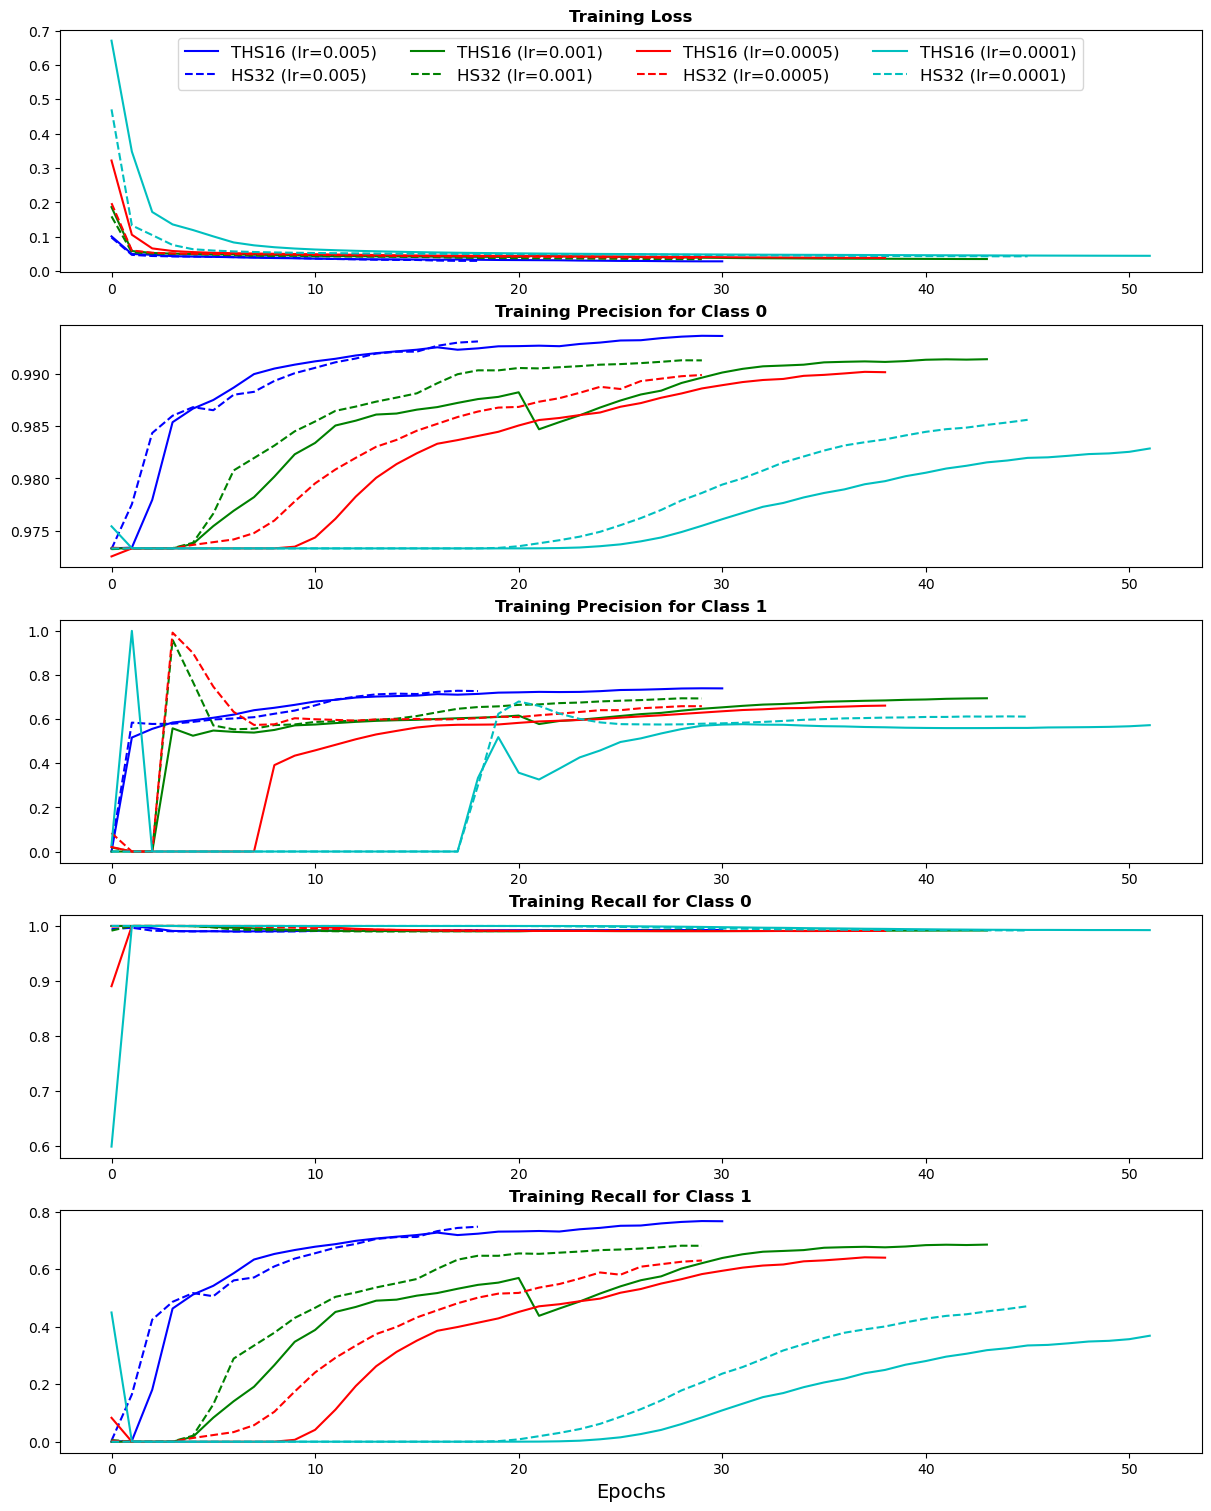

In [33]:
# comparing with previous hidden size
fig, axs = plt.subplots(5, 1, figsize=(12, 15), layout='constrained')
ax1, ax2, ax3, ax4, ax5 = axs


for (lr, c) in zip(lrs, colors):
    ax1.plot(train_losses_all[lr], color=c, linestyle='-', label=f'THS16 (lr={lr})')
    ax1.plot(train_losses_all_new[lr], color=c, linestyle='--', label=f'HS32 (lr={lr})')
    ax1.set_title('Training Loss', fontweight='bold')

    train_precisions = np.array(train_precisions_all[lr])
    train_precisions_new = np.array(train_precisions_all_new[lr])

    ax2.plot(train_precisions[:, 0], color=c, linestyle='-', label=f'Train Precision HS16 (lr={lr})')
    ax2.plot(train_precisions_new[:, 0], color=c, linestyle='--', label=f'Train Precision HS32 (lr={lr})')
    ax2.set_title('Training Precision for Class 0', fontweight='bold')

    ax3.plot(train_precisions[:, 1], color=c, linestyle='-', label=f'Train Precision HS16 (lr={lr})')
    ax3.plot(train_precisions_new[:, 1], color=c, linestyle='--', label=f'Train Precision HS32 (lr={lr})')
    ax3.set_title('Training Precision for Class 1', fontweight='bold')

    train_recalls = np.array(train_recalls_all[lr])
    train_recalls_new = np.array(train_recalls_all_new[lr])

    ax4.plot(train_recalls[:, 0], color=c, linestyle='-', label=f'Train Recall HS16 (lr={lr})')
    ax4.plot(train_recalls_new[:, 0], color=c, linestyle='--', label=f'Train Recall HS32 (lr={lr})')
    ax4.set_title('Training Recall for Class 0', fontweight='bold')

    ax5.plot(train_recalls[:, 1], color=c, linestyle='-', label=f'Train Recall HS16 (lr={lr})')
    ax5.plot(train_recalls_new[:, 1], color=c, linestyle='--', label=f'Train Recall HS32 (lr={lr})')
    ax5.set_title('Training Recall for Class 1', fontweight='bold')

# show all labels
ax1.legend(fontsize='large', loc='upper center', ncol=4)
ax5.set_xlabel("Epochs", fontsize=14)